In [ ]:
!pip install yfinance
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install statsmodels
!pip install sklearn

!pip install statsmodels --upgrade

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.11.1)


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.optimize import differential_evolution
import warnings
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
from numpy import log
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

In [ ]:
# import data
start_dt = '2020'
end_dt = '2020-07-17'
data = yf.Ticker('GC=F').history(period="max").loc[start_dt:end_dt]['Close']
data.head()

Date
2020-01-02    1524.5
2020-01-03    1549.2
2020-01-05    1571.3
2020-01-06    1566.2
2020-01-07    1571.8
Name: Close, dtype: float64

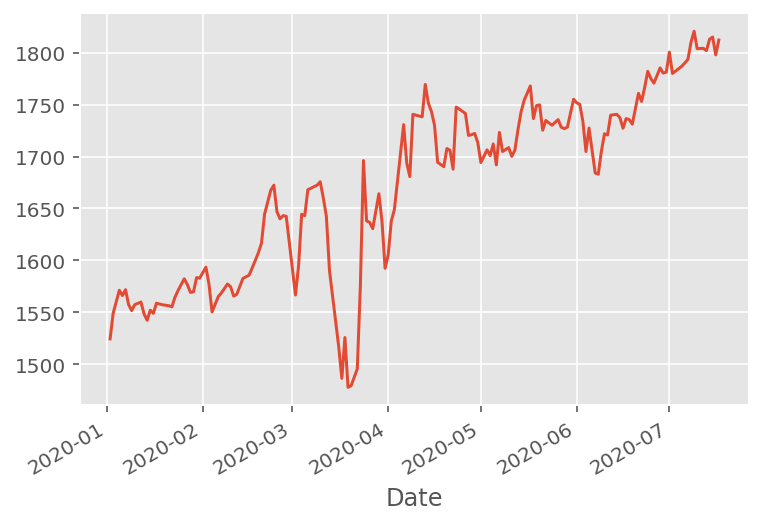

In [ ]:
data.plot()

In [ ]:
# train/test data set

split_point = len(data) - 7
dataset, validation = data[0:split_point], data[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

Dataset 154, Validation 7


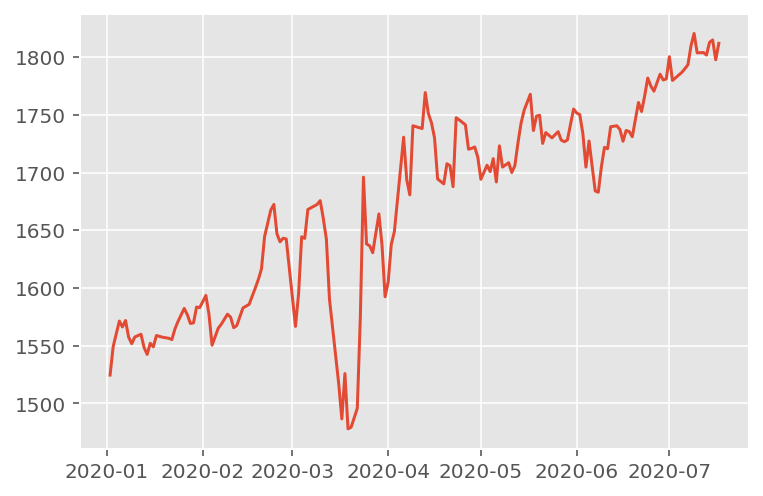

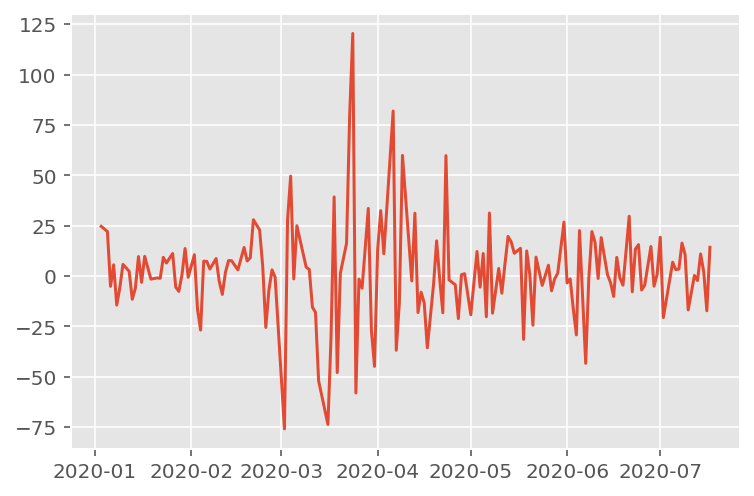

ADF Statistic: -3.909962
p-value: 0.001963
	1%: -3.475
	5%: -2.881
	10%: -2.577


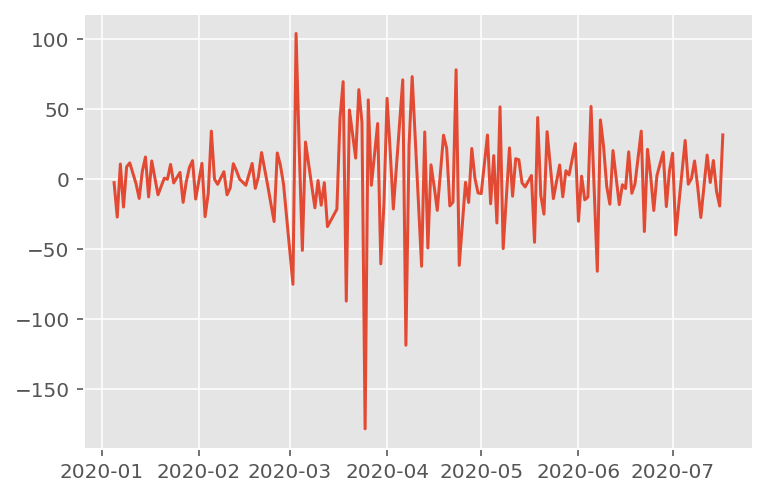

ADF Statistic: -6.729519
p-value: 0.000000
	1%: -3.476
	5%: -2.882
	10%: -2.578


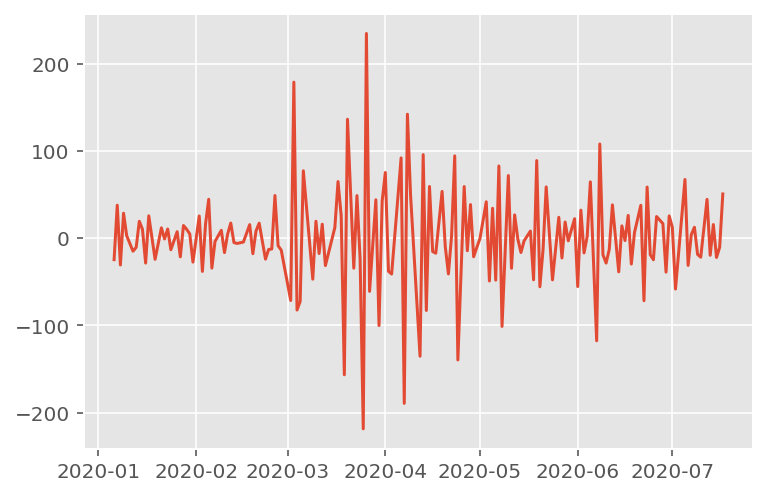

ADF Statistic: -8.372496
p-value: 0.000000
	1%: -3.477
	5%: -2.882
	10%: -2.578


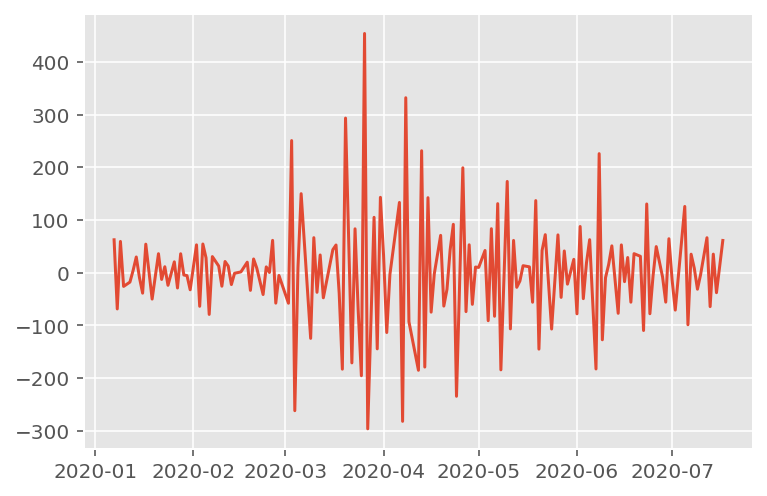

ADF Statistic: -8.727905
p-value: 0.000000
	1%: -3.477
	5%: -2.882
	10%: -2.578


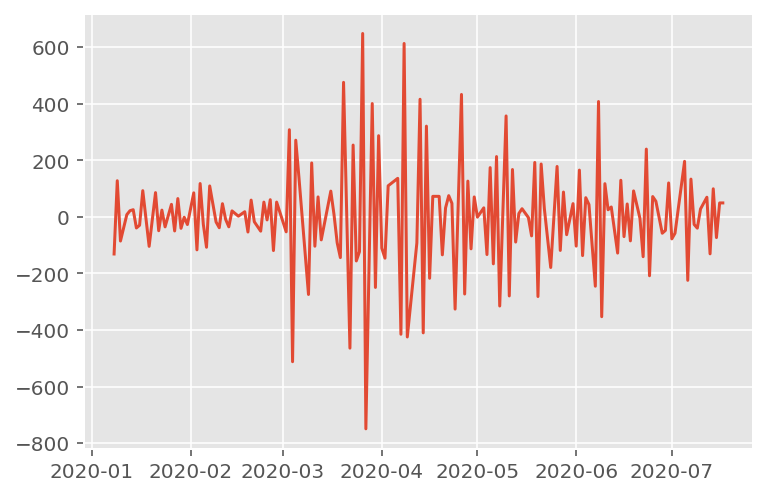

ADF Statistic: -8.380892
p-value: 0.000000
	1%: -3.478
	5%: -2.882
	10%: -2.578


In [ ]:
#difference and test for stationarity
xdiff = data
plt.plot(xdiff)
plt.show()

times = 5
for i in range(times):

  xdiff = xdiff.diff()
  plt.plot(xdiff)
  plt.show()
  result = adfuller(xdiff.dropna().values)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

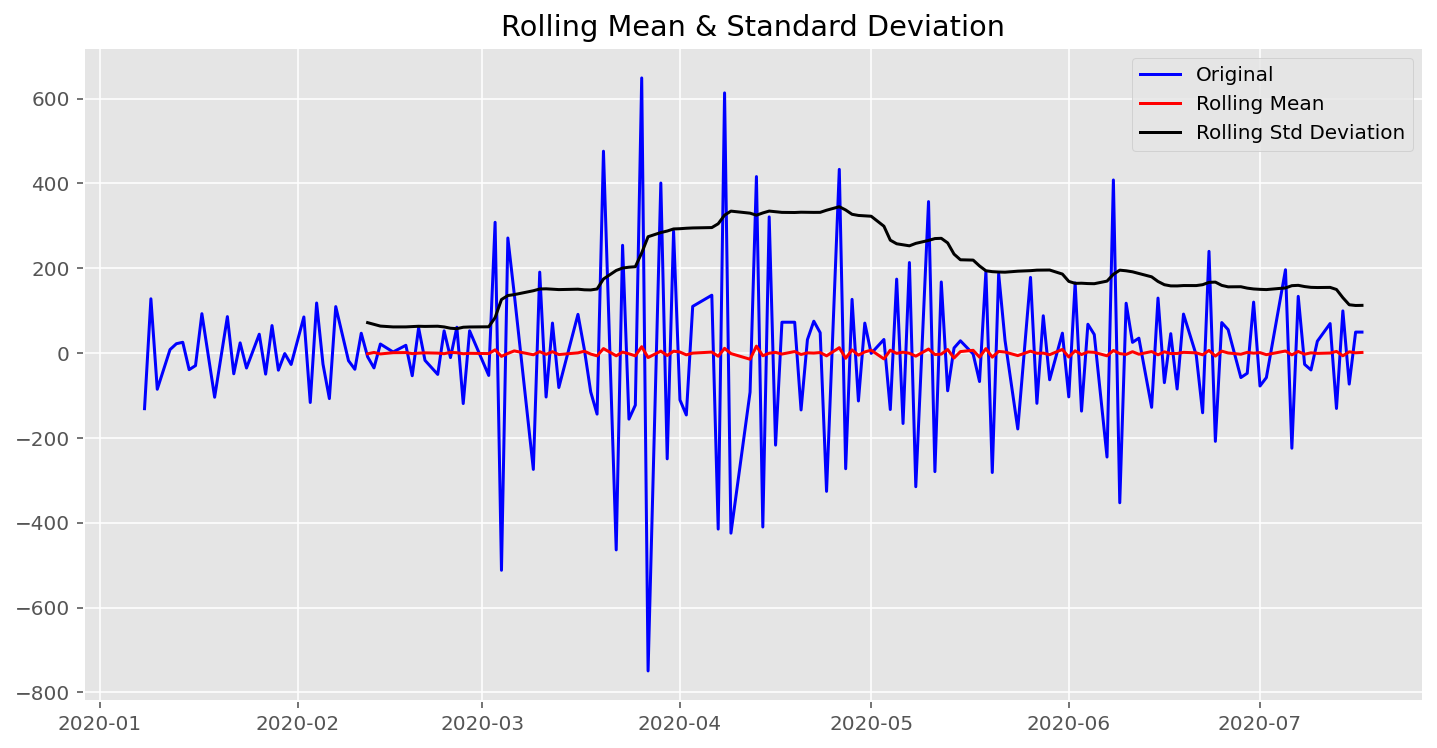

In [ ]:
rolmean = xdiff.rolling(30).mean()
rolstd = xdiff.rolling(30).std()

plt.figure(figsize=(12, 6))
orig = plt.plot(xdiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

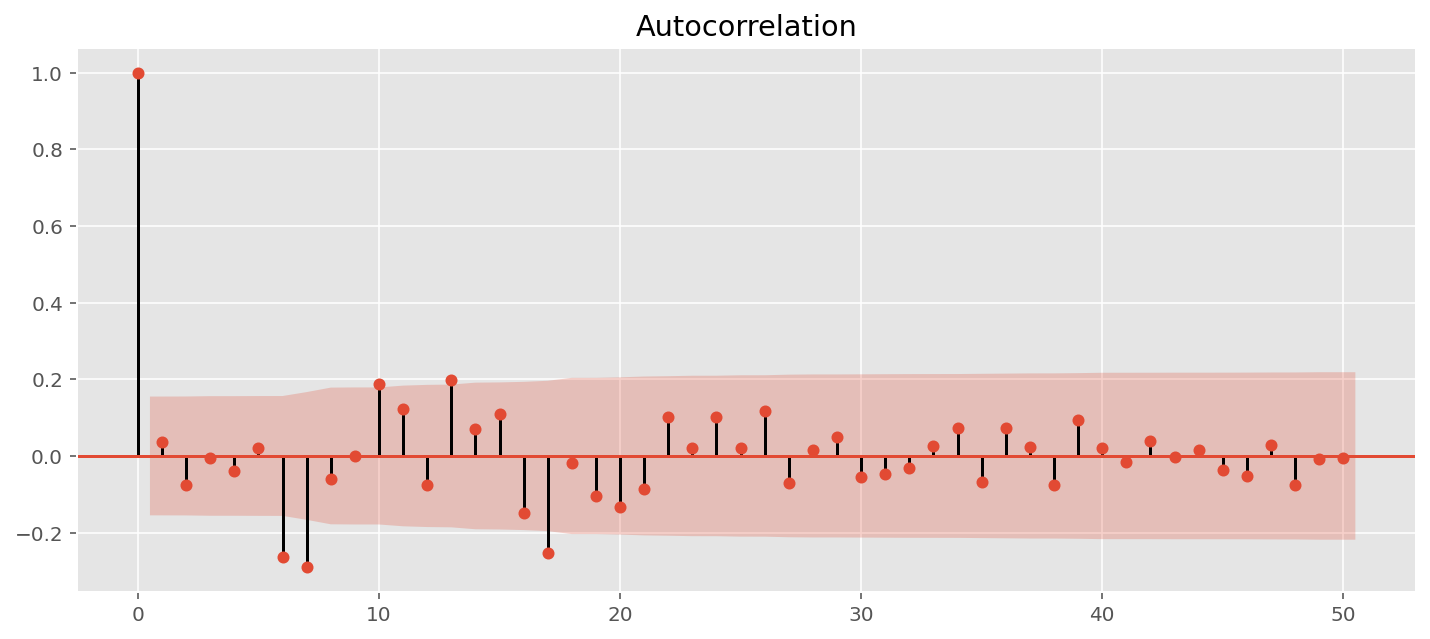

In [ ]:
xdiff = xdiff.dropna()
# autocorrelation
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(xdiff.values, lags=50, ax=ax)
plt.show()

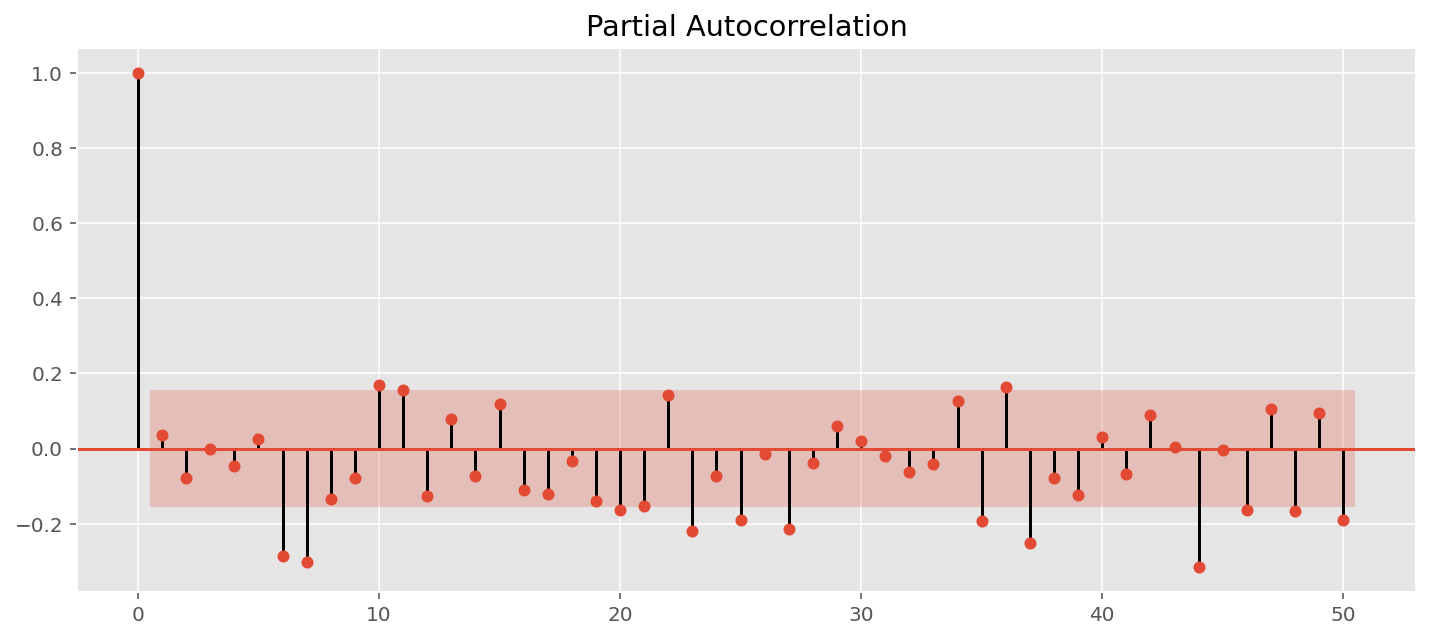

In [ ]:
#pacf
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(xdiff.values, lags=50, ax=ax)
plt.show()

In [ ]:
# playing around with initial guesses for params
p = 5
d = 1
q = 1
X = xdiff.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

model = ARIMA(X,(p,d,q)).fit()
model.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  159
Model:                 ARIMA(5, 1, 1)   Log Likelihood                 442.904
Method:                       css-mle   S.D. of innovations              0.015
Date:                Tue, 21 Jul 2020   AIC                           -869.807
Time:                        17:53:28   BIC                           -845.256
Sample:                             1   HQIC                          -859.837
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.243e-06   2.42e-05     -0.051      0.959   -4.87e-05    4.62e-05
ar.L1.D.y      0.0405      0.080      0.508      0.611      -0.116       0.197
ar.L2.D.y     -0.0727      0.080     -0.912      0.362      -0.229       0.083
ar.L3.D.y      0.0064      0.080      0.080      0.936      -0.150       0.163
ar.L4.D.y     -0.0423      0.079     -0.534      0.593      -0.197       0.113
ar.L5.D.y      0.0270      0.079      0.341      0.733      -0.128       0.182
ma.L1.D.y     -0.9999      0.016    -61.450      0.000      -1.032      -0.968
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3659           -1.3001j            1.8857           -0.3789
AR.2           -1.3659           +1.3001j            1.8857            0.3789
AR.3            0.8493           -1.8123j            2.0015           -0.1803
AR.4            0.8493           +1.8123j            2.0015            0.1803
AR.5            2.5994           -0.0000j            2.5994           -0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
# instead of manually setting params -> grid search for optimal arima params

def arima(X, order, returnMod = False):
  # prepare training dataset
  train_size = int(len(X) * 0.66)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
	
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
	# calculate out of sample error
  error = mean_squared_error(test, predictions)
  if returnMod:
    return model_fit
  else:
    return error

def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          mse = arima(dataset, order)
          if mse < best_score:
	          best_score, best_cfg = mse, order
          print('ARIMA%s MSE=%.3f' % (order,mse))
        except:
          continue
  print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
# parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
#warnings.filterwarnings("ignore")
evaluate_models(data.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=12423.268
ARIMA(0, 0, 1) MSE=3918.963
ARIMA(0, 0, 2) MSE=2239.251
ARIMA(0, 1, 0) MSE=222.855
ARIMA(0, 1, 1) MSE=227.679
ARIMA(0, 1, 2) MSE=227.544
ARIMA(0, 2, 0) MSE=540.063
ARIMA(0, 2, 1) MSE=227.758
ARIMA(0, 2, 2) MSE=233.522
ARIMA(1, 0, 0) MSE=264.388
ARIMA(1, 0, 1) MSE=276.063
ARIMA(1, 0, 2) MSE=273.712
ARIMA(1, 1, 0) MSE=226.878
ARIMA(1, 1, 1) MSE=215.492
ARIMA(1, 1, 2) MSE=216.753
ARIMA(1, 2, 0) MSE=372.641
ARIMA(1, 2, 1) MSE=232.637


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/s

ARIMA(1, 2, 2) MSE=214.107
ARIMA(2, 0, 0) MSE=275.155
ARIMA(2, 0, 1) MSE=270.321


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/s

ARIMA(2, 0, 2) MSE=248.332
ARIMA(2, 1, 0) MSE=228.566


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


ARIMA(2, 1, 1) MSE=238.305


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


ARIMA(2, 2, 0) MSE=297.788


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1) MSE=234.090


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianI

ARIMA(2, 2, 2) MSE=227.506
ARIMA(4, 0, 0) MSE=274.600
ARIMA(4, 0, 1) MSE=272.217


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/pyt

ARIMA(4, 1, 0) MSE=226.290
ARIMA(4, 1, 1) MSE=227.802


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(4, 1, 2) MSE=212.849
ARIMA(4, 2, 0) MSE=295.805


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 2, 1) MSE=232.234


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(4, 2, 2) MSE=233.375
ARIMA(6, 0, 0) MSE=280.498
ARIMA(6, 0, 1) MSE=286.121


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianI

ARIMA(6, 0, 2) MSE=304.205
ARIMA(6, 1, 0) MSE=245.494
ARIMA(6, 1, 1) MSE=233.146
ARIMA(6, 1, 2) MSE=230.107
ARIMA(6, 2, 0) MSE=307.029
ARIMA(6, 2, 1) MSE=250.904
ARIMA(6, 2, 2) MSE=238.448
ARIMA(8, 0, 0) MSE=252.635
ARIMA(8, 0, 1) MSE=252.255
ARIMA(8, 0, 2) MSE=259.030
ARIMA(8, 1, 0) MSE=221.064
ARIMA(8, 1, 1) MSE=222.149
ARIMA(8, 1, 2) MSE=232.283
ARIMA(8, 2, 0) MSE=269.444
ARIMA(8, 2, 1) MSE=226.298


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 2, 2) MSE=227.224
ARIMA(10, 0, 0) MSE=256.973
ARIMA(10, 0, 1) MSE=261.571


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


ARIMA(10, 1, 0) MSE=238.933
ARIMA(10, 1, 1) MSE=240.845
ARIMA(10, 2, 0) MSE=272.383
ARIMA(10, 2, 1) MSE=266.495
Best ARIMA(4, 1, 2) MSE=212.849


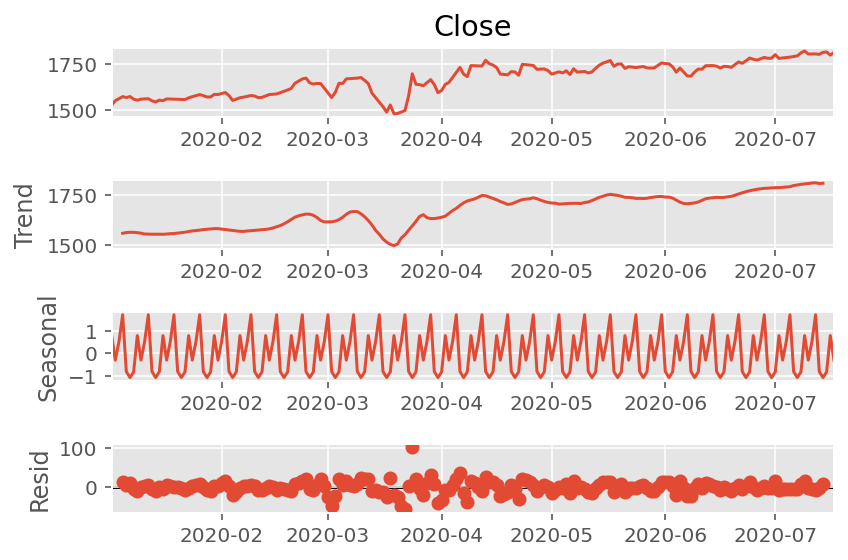

In [ ]:
# decompose
decomposition = sm.tsa.seasonal_decompose(data.asfreq('d').interpolate(method='time'), model='additive')
fig = decomposition.plot()
plt.show()

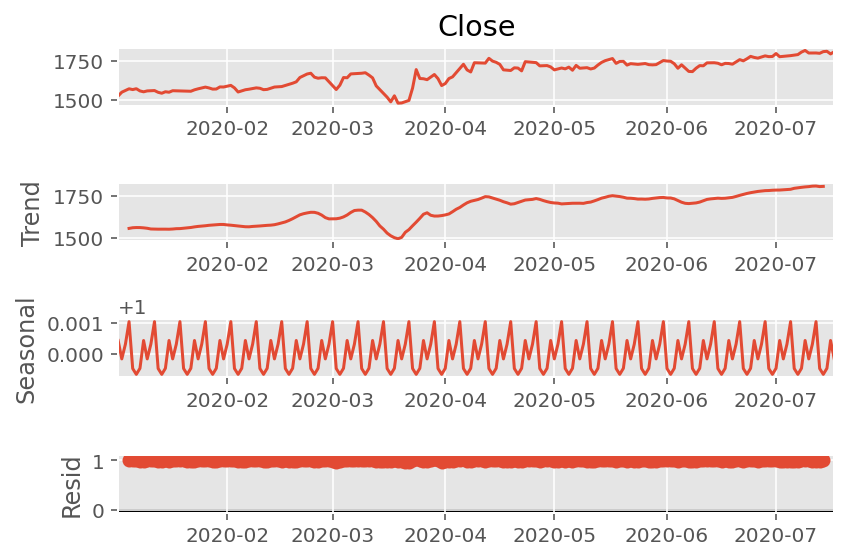

In [ ]:
# decompose
decomposition = sm.tsa.seasonal_decompose(data.asfreq('d').interpolate(method='time'), model='multiplicative')
fig = decomposition.plot()
plt.show()

In [ ]:
mod = ARIMA(data, order=(4,1,2))
mod.fit()
predictions = mod.fit().predict()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
#expanding window

X = data.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(4,1,2))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=1714.895849, expected=1725.800000
predicted=1726.592933, expected=1742.800000
predicted=1746.723537, expected=1754.100000
predicted=1752.008010, expected=1767.900000
predicted=1766.355868, expected=1736.500000
predicted=1732.868583, expected=1749.000000
predicted=1750.168111, expected=1749.700000
predicted=1746.916745, expected=1725.300000
predicted=1728.581387, expected=1734.700000
predicted=1737.051246, expected=1730.100000
predicted=1732.867441, expected=1735.500000
predicted=1740.843782, expected=1728.200000
predicted=1731.209535, expected=1726.800000
predicted=1733.086582, expected=1728.300000
predicted=1732.789520, expected=1755.100000
predicted=1760.526362, expected=1751.700000
predicted=1753.147739, expected=1750.300000
predicted=1754.338978, expected=1734.000000
predicted=1735.778460, expected=1704.800000
predicted=1712.251466, expected=1727.400000
predicted=1735.752482, expected=1684.100000
predicted=1693.584962, expected=1683.000000
predicted=1699.099311, expected=

In [ ]:
forecast = model_fit.forecast(7)[0]

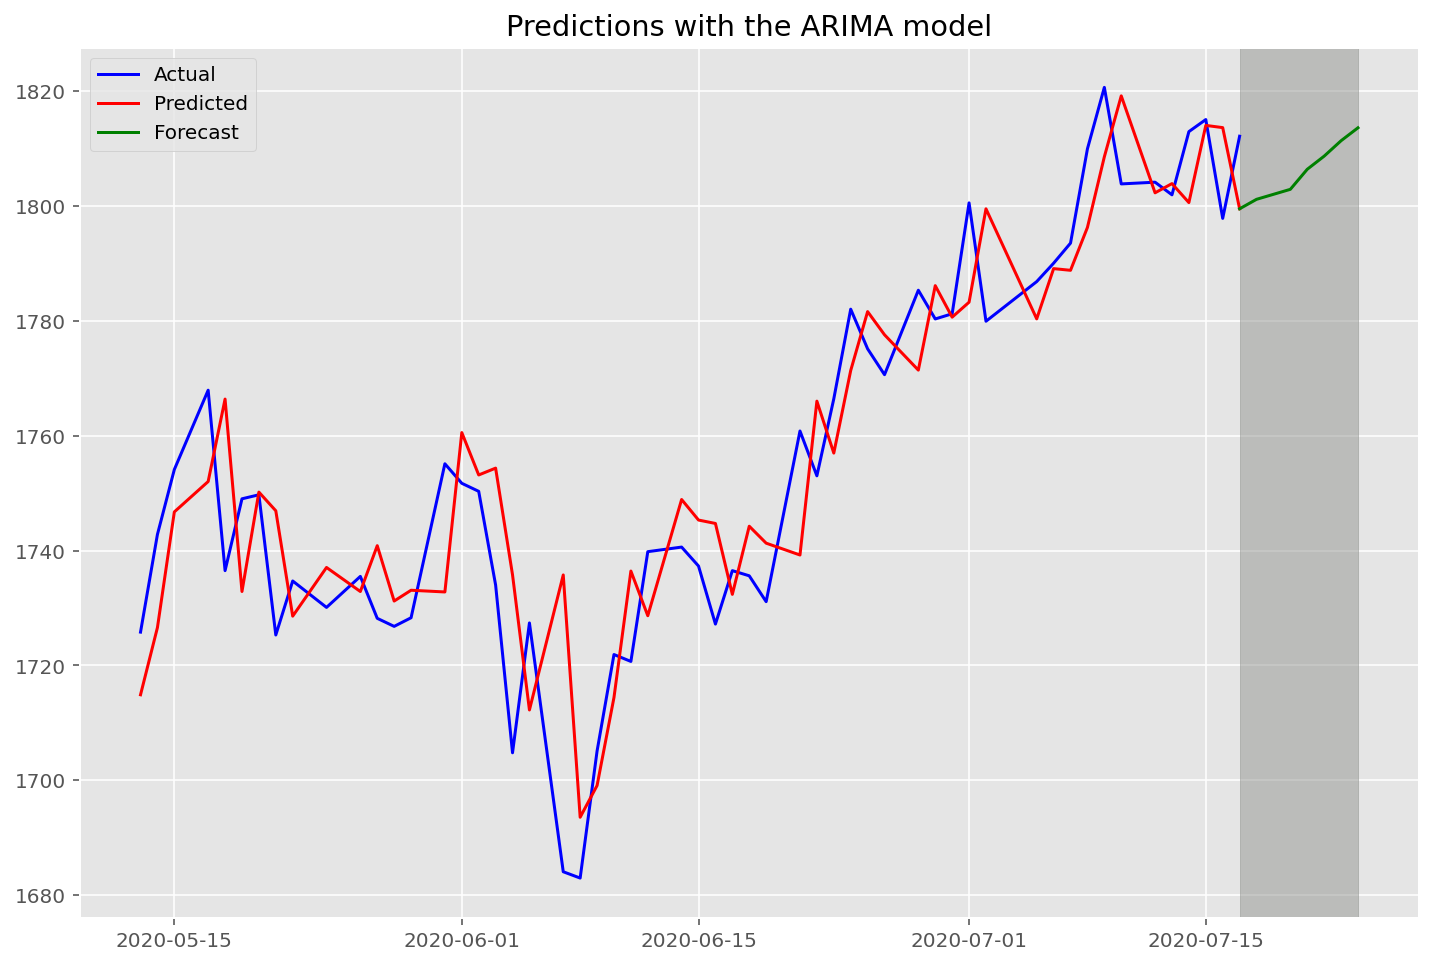

In [ ]:
# plot real, predicted, forecast
plt.figure(figsize=(12, 8))
plt.title('Predictions with the ARIMA model')

plt.plot(data.index[size:len(X)], test, color = 'blue', label = 'Actual')
plt.plot(data.index[size:len(X)],predictions, color='red', label = 'Predicted')
plt.plot(data.index[-8:-1].shift(8, freq = "d"), forecast, color = 'green', label = "Forecast")

plt.legend()

#shading the area we are forecasting
plt.axvspan(data.index[-8:-7].shift(8, freq = "d"),
            data.index[-2:-1].shift(8, freq = "d"), color=sns.xkcd_rgb['grey'], alpha=0.5)

plt.show()

In [ ]:
# forecast for 7th day / july 24
forecast[-1]

1813.5674571571726

<BarContainer object of 160 artists>

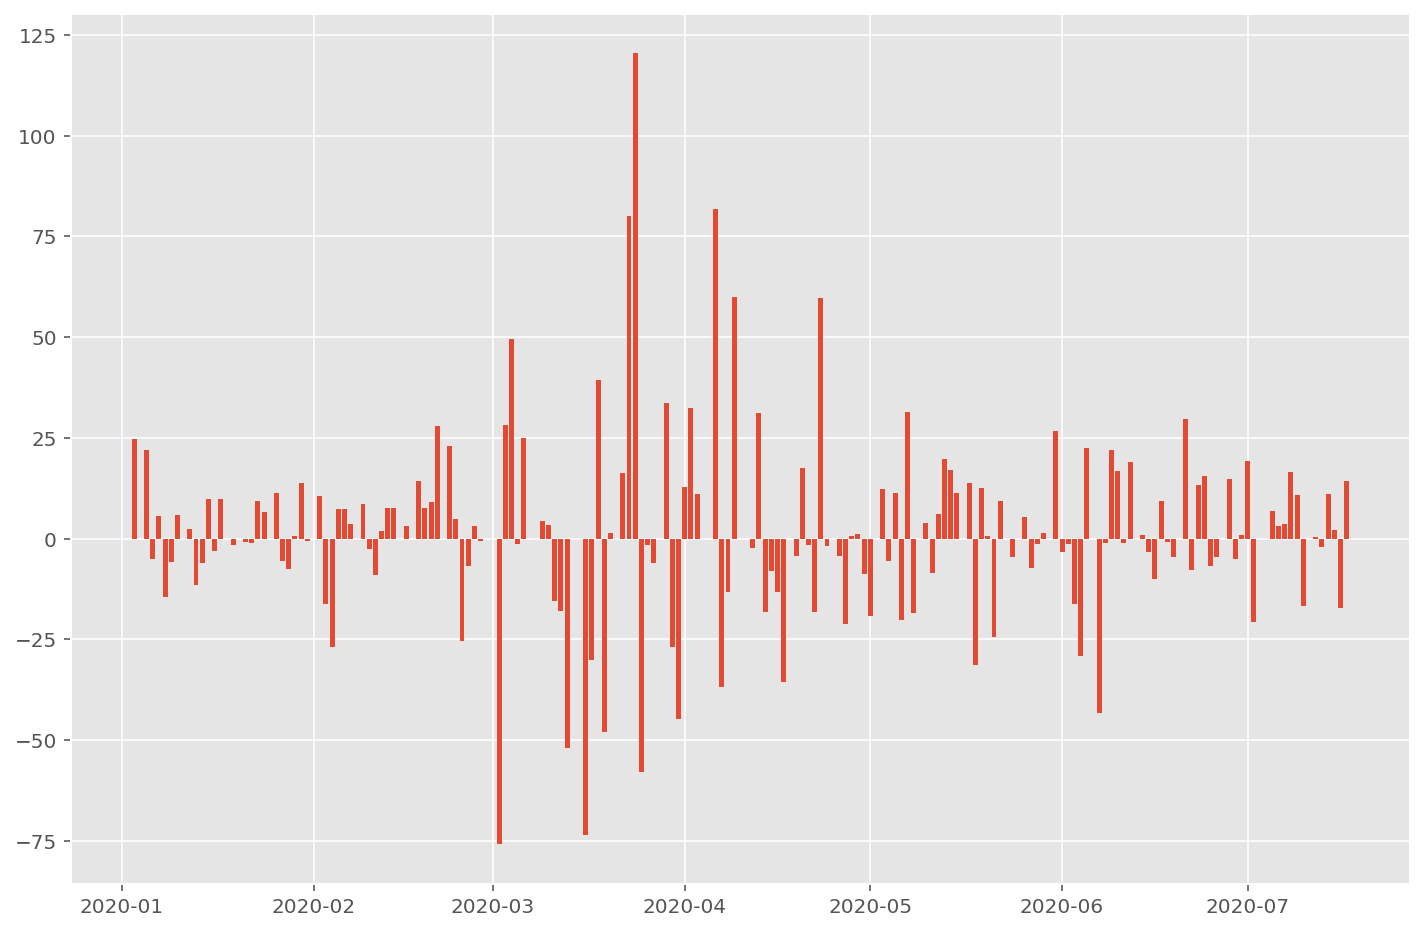

In [ ]:
# change in stock (first diff)
plt.figure(figsize=(12, 8))

plt.bar(data.index[1:],data.diff().dropna(), )
